# Calculate magnitudes of the stars

Written by Evgenii N.

This code calculates the magnitudes of stars.

## Prerequisite code

In [54]:
# Import libraries that we will use later in this notebook
import os
import shutil
import ccdproc
import numpy as np
from astropy.visualization import ZScaleInterval, MinMaxInterval, ImageNormalize
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from matplotlib.colors import LogNorm
from ccdproc import CCDData
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.centroids import centroid_2dg, centroid_com, centroid_1dg
from scipy.ndimage import shift

# Make images non-blurry on high pixel density screens
%config InlineBackend.figure_format = 'retina'


def set_plot_style():
    """Set global style"""

    # Title size
    plt.rcParams['axes.titlesize'] = 20

    # Axes label size
    plt.rcParams['axes.labelsize'] = 16

    # Tick label size
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    
    # Legend text size
    plt.rcParams['legend.fontsize'] = 14

    # Grid color
    plt.rcParams['grid.color'] = '#cccccc'

    # Define plot size
    plt.rcParams['figure.figsize'] = [12, 8]


def show_image(image, title, apertures=None):
    """
    Display an image.
    
    Parameters
    ---------
    
    image: astropy.nddata.ccddata.CCDData
        A fits image to show.
        
    title: str
        Plot title.
        
    apertures: list of CircularAperture
        List of apertures to plot over the image, optional.
    """
    
    # Scale the image similar to 'zscale' mode in DS9.
    # This makes easier to spot things in the image.
    interval=ZScaleInterval()
    vmin, vmax = interval.get_limits(image)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    
    plt.imshow(image, cmap='gray', norm=norm)  # Set color map and pixel scaling
    plt.xlabel('x [pixel]')  # Set axis labels
    plt.ylabel('y [pixel]')
    plt.title(title, y=-0.2)  # Set image title
    plt.colorbar()  # Show color bar
    
    if apertures is not None:
        apertures.plot(color='#33ff33', lw=2, alpha=0.8)
    

def print_image_stats(image, title):
    """
    Print first pixel value, average and standard deviation for an image.
    
    Parameters
    ---------
    
    image: astropy.nddata.ccddata.CCDData
        A fits image to show.
        
    title: str
        Image name.
    """
    
    data = np.asarray(image)# Get numpy array for image data
    label_len = 10  # Length of the text label
    first_pixel = data[0, 0]  # First pixel
    average = np.mean(data)  # Average
    standard_deviation = np.std(data)   # Standard deviation


    # Print values
    # -------

    print(
        f'\n{title}',
        f"\n{'-' * len(title)}",
        f"\n{'Pixel:':<10}{first_pixel:>10.2f} ADU",
        f"\n{'Avg:':<10}{average:>10.2f} ADU",
        f"\n{'Std:':<10}{standard_deviation:>10.2f} ADU\n"
    )
    

def save_image(image, file_path):
    """
    Save image to disk. Overwrites the file if it already exist.
    
    Parameters
    ---------
    image: astropy.nddata.ccddata.CCDData
        Image to be saved
        
    file_path: str
        Path where the image is saved
    """
    
    # Delete the file if it already exists
    
    try:
        os.remove(file_path)
    except OSError:
        pass
    
    # Create directory
    # ------

    dirname = os.path.dirname(file_path)
    
    if not os.path.exists(dirname):
        os.makedirs(dirname)

    image.write(file_path)

## Selecting reference stars

I have choosen the reference stars shown in Table 1. These are the stars that I will use to calculate marnitudes of all other stars in non-photometric night image (March 9) using the photometric callibrations (Eq. 1-4) and measurements from photometric night image (March 29). I have chosen the stars using the following method:

* In DS9, opened images for all filters from photometric night, located in code/050_scaling_and_combining/march_29_2018_stacked directory and well as code/040_shift/data/shifted/march_29_2018/NGC_3201_B_30.000secs_00000472.fit image.

* Chose Zoom > Invert Y in DS9.

* In DS9, opened images for all filters from non-photometric night, located in code/050_scaling_and_combining/march_09_2018_stacked directory. 

* Chose Zoom > Invert X in DS9. Now all FITS images are in same orientation. The images also almost match orientation on Aladin Lite web site: our fits files are rotated about 3 degrees clockwise with respect to Aladin.

* First I use the B-filter photometric image and look at stars that are visible on it (meaning they have significant blue component).

* Then, I locate those stars on other FITS images and make sure they are not oversaturated, meaning that the radius is not larger than 10 pixels.

* I make sure there are no other bright stars closer than 20 pixels. Our science images are oversaturated and it is hard to distibuish stars in the center of the cluter. Because of this, I used stars far away from the center.

Table 1: X-y pixel coordinates of stars from photomoteric (March 29 2018) and non-photometric (March 9 2018) images. RA/DEC coordinates and apparent B, V magnitudes are taken from SIMBAD database using Aladin Lite web site.

| #  | x, y position, March 29 2018 | x, y position, March 9 2018 | RAJ2000 [deg]  | DEJ2000 [deg]  | B   | V   |
|:---|:---------------------------:|:----------------------------:|:--------------:|:--------------:|:---:|:---:|
|  1 |           739, 468          |            49, 28            | 154.3111238862 | -46.4466457933 | 14.730 | 13.800 |
|  2 |           495, 440          |            294, 57           | 154.3751324274 | -46.4435287544 | 15.146 | 14.021 |
|  3 |           665, 128          |            124, 371           | 154.3346246701 | -46.3859927913 | 15.020 | 13.870 |
|  4 |           461, 81          |            329, 418           | 154.3882668536 | -46.3793802270 | 15.560 | 14.770 |
|  5 |           136, 251          |            654, 246           | 154.4705311270 | -46.4124240426 | 15.520| 14.540 |

Locations of the reference stars in the images are shown on Fig 1.

<img width="500px" alt="Reference stars" src="images/reference_stars.jpg">
Figure 1: Five reference stars from Table 1. Top: photometric image from March 29 2018, B-band, y-axis is inverted. Middle: non-photometric image, March 9 2018, I-band, x-axis is inverted. Bottom: view of the cluster from Aladin Lite selected stars are from  SIMBAD database.

## Photometric callibation

The following equations are photometric calibrations for March 9 2018 image, supplied to us by teachers:

$B = 19.237 - 2.5 \log(f/t) - 0.330*A \tag{1}$

$V = 19.696 - 2.5 \log(f/t) - 0.210*A \tag{2}$

$R = 19.679 - 2.5 \log(f/t) - 0.119*A \tag{3}$

$I = 19.079 - 2.5 \log(f/t) - 0.134*A \tag{4},$

where

* $A$ is the airmass number, taken from AIRMASS value from header of the FITS file,

* $f$ is the star's flux we measure in the image, in ADU,

* $t$ is exposure time of the frame, in seconds.

In [29]:
def calculate_flux(data, position, radius):
    """
    Return flux at given position.
    
    Parameters
    ---------
    
    data: numpy.ndarray
        2D array containing image data.
        
    position: (float, float)
        Image position [pixel].
        
    radius: float
        Aperture radius.
        
    Returns
    ------
    float
        Flux [ADU]
    """
    
    # Create aperture object
    apertures = CircularAperture(position, r=radius) 
    
    # Calculate flux of the souce that is inside of the circle
    fluxes = aperture_photometry(data, apertures)

    # Get the flux value
    flux = fluxes[0]["aperture_sum"]
    
    return flux

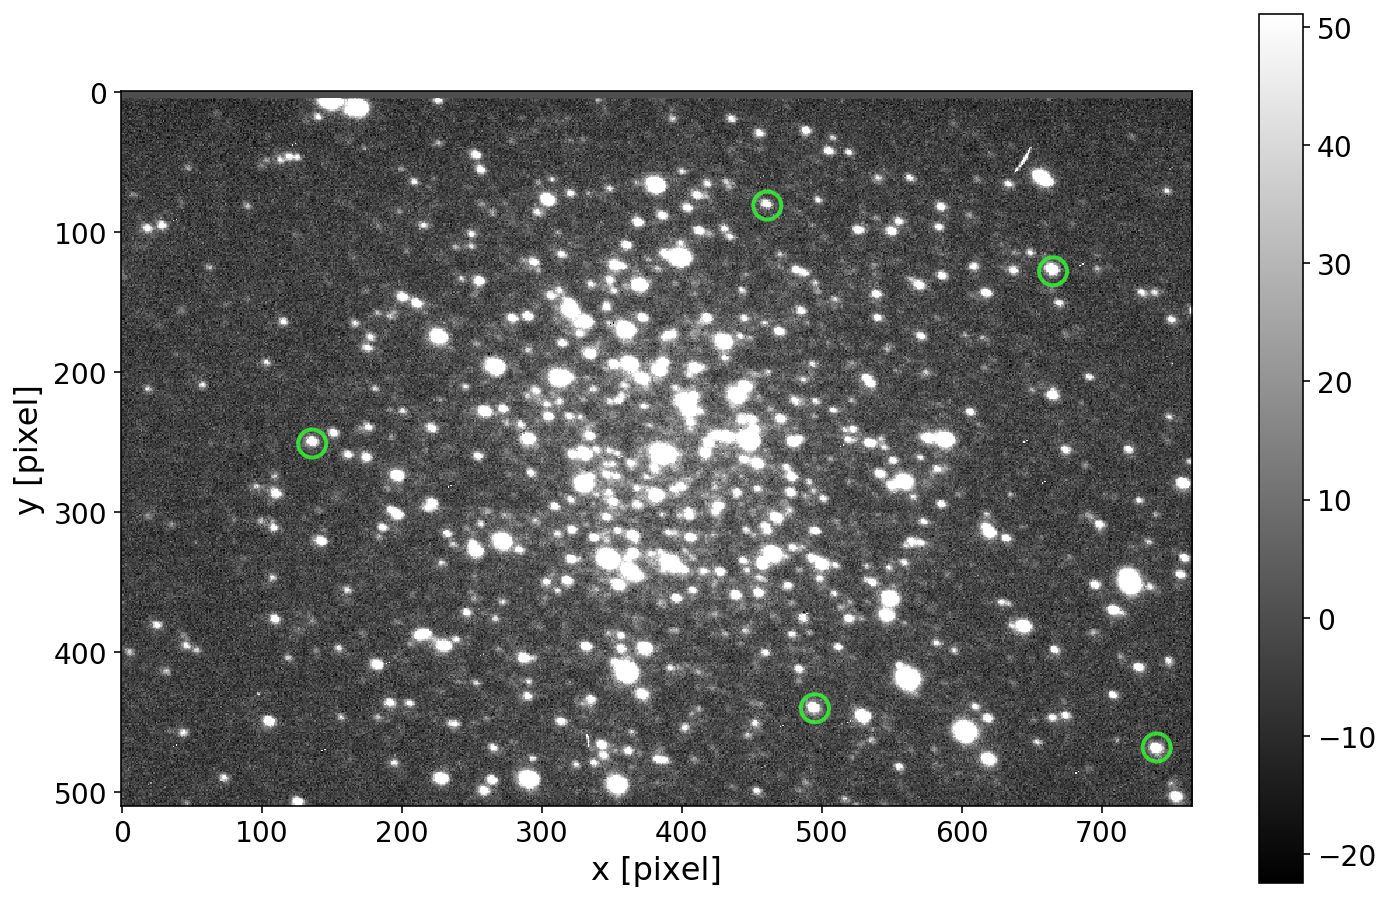

In [55]:
set_plot_style()

"""
Reference stars: list of dict
    non_photometric: (int, int)
        (x,y) pixel coordinate of the star in non_photometric images.

    photometric: (int, int)
        (x, y) pixel coordinate of the star in photometric images.

    b_mag_simbad, v_mag_simbad: float
        B and V apparent magnitues of the star from SIMBAD database.
"""
reference_stars = [
    dict(photometric=(739, 468), non_photometric=(49, 28), b_mag_simbad=14.730, v_mag_simbad=13.800),
    dict(photometric=(495, 440), non_photometric=(294, 57), b_mag_simbad=15.146, v_mag_simbad=14.021),
    dict(photometric=(665, 128), non_photometric=(124, 371), b_mag_simbad=15.020, v_mag_simbad=13.870),
    dict(photometric=(461, 81), non_photometric=(329, 418), b_mag_simbad=15.560, v_mag_simbad=14.770),
    dict(photometric=(136, 251), non_photometric=(654, 246), b_mag_simbad=15.520, v_mag_simbad=14.540)
]

photometric_images = [
    dict(filter="I",
         path="../050_scaling_and_combining/march_29_2018_stacked/NGC_3201_I_median_30.0s.fits"), b_mag_simbad=14.730, v_mag_simbad=13.800)
]


reference_image_path = "../050_scaling_and_combining/march_29_2018_stacked/NGC_3201_I_median_30.0s.fits"
reference_image = CCDData.read(reference_image_path)
reference_positions = [ reference_star["photometric"] for reference_star in reference_stars ]
reference_apertures = CircularAperture(reference_positions, r=10)


    # Find the flux
#     flux = calculate_flux(data=reference_image.data, position=reference_star["photometric"], radius=10)
#     print(f'f2 = {flux:.0f} ADU')
    
show_image(image=reference_image, apertures=reference_apertures, title="")